# Entrega 5.2 - Jugador de Damas Chinas (Q Learning, Redes Neuronales)

### Grupo 07:
     - Renzo Gambone C.I. 5.155.486-4
     - Germán Ouviña C.I. 4.823.566-1
     - Leandro Rodríguez C.I 4.691.736-4


## 1. Introducción
***
### 1.1. Objetivo
***
A

### 1.2. Entrega
***
A

### 1.3. Formato
***
A

## 2. Diseño
***
En esta sección se detallan ciertas nociones técnicas en lo que refiere al juego de las damas chinas, la implementación dada del mismo y las características de diseño utilizadas para construir el modelo.

En lo que respecta a los modelos, se aprovecha para denotar cuales parámetros se mantuvieron fijos y cuales parámetros y características se decidieron variar a lo largo de la experimentación.

### 2.1. Juego (*)
***
El juego **Damas Chinas** cuenta con múltiples variantes y reglas distintas. A continuación se especifican las reglas de su forma básica, así como los cambios implementados en este escenario con el motivo de simplificar u optimizar la resolución del problema:

**Jugadores:**
> - Puede haber entre 2 y 6 jugadores, los cuales juegan todos contra todos.
> - Cada jugador cuenta con 10 piezas.
> - *Simplificación:* Se limita la participación a 2 jugadores, con el objetivo de simplificar el problema a representar.

**Tablero:**
> - El tablero tiene forma de estrella de 6 puntas, el cual cuenta con 121 casillas dispuestas en forma hexagonal.
> - Esto implica que cada celda cuenta con 6 celdas adyacentes, a diferencia de una grilla rectangular, donde cada celda tiene 9 celdas adyacentes.
> - Cada jugador puede mover sus piezas hacia las celdas adyacentes que no estén ocupadas, o saltar piezas (suyas o del oponente) siempre y cuando el salto sea siguiendo la recta que contiene la pieza que salta y la pieza saltada.
> - Cada jugador comienza con sus 10 piezas en una punta de la estrella.
> - *Simplificación:* Se limita el tablero a ser un rombo de 81 casillas, eliminando los 4 triángulos que se encuentran a los lados del tablero. Dicha simplificación se realiza ya que en un juego entre 2, la existencia de dichos triángulos no tiene relevancia y solo agrega complejidad al representar el tablero.

<div>
    <div style="display: inline-block; width: 49%; text-align: center;">
        <img src="img/tableroOriginal.jpg" />
        <label style="margin-top: 16px; font-size: 16px; font-family: monospace;"> Figura 1 - Tablero original </label>
    </div>
    <div style="display: inline-block; width: 49%; text-align: center;">
        <img src="img/tableroSimple.jpg" />
        <label style="margin-top: 16px; font-size: 16px; font-family: monospace;"> Figura 2 - Tablero simplificado </label>
    </div>
</div>

**Objetivo:**
> - El objetivo de un jugador es depositar todas sus fichas en el triángulo opuesto a su triángulo de inicio.
> - El juego se termina cuando uno de los jugadores cumple dicho objetivo, no existiendo posibilidad de empate.
> - *Simplificación:* Debido a que es posible que un partido se extienda en el tiempo tanto como los jugadores lo deseen, se agrega la posibilidad de **empatar** una partida, declarándose dicho empate luego de pasada una cierta cantidad configurable de turnos (por defecto 300).

**Complejidad:**
> - A diferencia del Go y las fichas no coronadas en las damas, en las damas chinas toda pieza puede moverse hacia atrás, adicionalmente un jugador podría realizar el movimiento inverso al movimiento previo, causando un bucle de movimientos que no alteran el estado final del campo.
> - *Simplificación:* Debido a la enorme cantidad de movimientos posibles (muchos de estos contraproducentes a la victoria del jugador), se definió restringir movimientos atrás por parte de los jugadores, (salvo que no haya movimientos posibles hacia adelante). También se decidió restringir movimientos inversos (que dejen las piezas del jugador en una disposición idéntica al tablero en los últimos turnos) a los últimos tres movimientos por parte del jugador (salvo que no haya más movimientos posibles).

En resumen, se realizan **5 modificaciones** a las reglas básicas del juego:
- Se limita la cantidad de jugadores a 2.
- Se transforma el tablero de una estrella de 121 casillas a un rombo de 81 casillas.
- Se agrega la posibilidad de empatar si no se logra terminar el juego luego de cierta cantidad de turnos.
- Sólo se permiten movimientos hacia atrás si el jugador no tiene más posibles movimientos hacia adelante.
- Se restringen movimientos inversos a los últimos tres realizados por el jugador (salvo que no queden más posibles movimientos). 

### 2.2. Tablero
***
Como ya se mencionó en la anterior sección, el tablero de **Damas Chinas** tiene una estructura particular. A continuación se trata el problema subdividiendo en varias secciones:

#### 2.2.1. Representación física y lógica (*)
***
Al tratarse de un tablero con una _grilla hexagonal_, no existe ninguna estructura predeterminada en Python para almacenarlo y mantener el movimiento de fichas sencillo e intuitivo. De esta forma, se generaron dos formas de representar el tablero: una **lógica** (para mostrarlo y realizar cálculos) y una **física** (para almacenarlo).

La **representación lógica** consta de un rombo de 81 casillas dispuestas hexagonalmente (cada casilla tiene 6 adyacentes excepto las de los extremos) las cuales cuentan con un par de _coordenadas axiales_ para representarlas. Dicho sistema de coordenadas cuenta con 2 ejes como un sistema cartesiano, con la diferencia de que dichos ejes no son perpendiculares. Para obtener una referencia visual, correr **script 1** al final de la sección.

La **representación física**, por otra parte, consta de una matriz cuadrada 9x9 de 81 casillas dispuestas las cuales cuentan con un par de _coordenadas cartesianas_ para representarlas (una matriz común y corriente). Existe una _biyección_ entre las casillas en la representación lógica y en la física. Dicha biyección permite obtener las coordenadas axiales de un par de coordenadas cartesianas, existiendo una función inversa que permite hacer lo contrario. La biyección se compone de dos transformaciones lineales consecutivas:

1. **Traslación del centro:** Partiendo de la matriz, la cual cuenta con el centro en (0,0) en una esquina, se traslada dicho centro a la celda (4,4) (el centro exacto de la matriz cuadrada).
2. **Agregado de los extremos:** Partiendo de la matriz con centro trasladado, se sustituyen todas las coordenadas y que sean mayores a 4 o menores a -4 restándoles o sumándoles 9 respectivamente.

Sea $f: R^2 \rightarrow R^2$ la expresión que representa a la biyección, con $f_1$ y $f_2$ las anteriores transformaciones:

- $f(x,y)=f_2(f_1(x,y))$

- $f_1(x,y)=(x-4, -y+4)$

- $f_2(x,y)=$
    - $(x,y)$ $\forall$ $(x,y)$ $:$ $|y| < 4$
    - $(x,y-9)$ $\forall$ $(x,y)$ $:$ $y \geq 4$
    - $(x,y+9)$ $\forall$ $(x,y)$ $:$ $y \leq -4$

Para obtener una referencia visual, correr **script 1** al final de la sección.

#### 2.2.2. Representación de atributos
***
Se optó por trabajar con dos representaciones posibles para los atributos.
- **Métricas:** (Empleadas previamente en el laboratorio 1), estas mismas aportan un mayor grado de abstracción en la representación del tablero, esto permita acoplar tableros no necesariamente iguales en términos de la distribución de sus piezas pero sí en términos de "particularidades de la distribución de las mismas".
- **Tablero:** La disposición física de piezas en el tablero, denotando para cada celda si está vacia, tiene una pieza del jugador 1 o tiene una pieza del jugador 2.

##### 2.2.2.1. Métricas (*)
***
Se determinaron **4 métricas**, las cuales deberían reflejar lineamientos generales sobre que tan bien o mal está jugando el jugador _i_, estas son:
1. **$A_i$** - **Suma cuadrada de la distancia de cada pieza del jugador _i_ hacia el objetivo.** El objetivo de esta métrica es incitar al jugador _i_ a mover sus piezas al extremo opuesto del tablero.
2. **$B_i$** - **Suma cuadrada de la distancia de cada pieza del jugador _i_ hacia la línea vertical que representa el centro del tablero.** El objetivo de esta métrica es incitar al jugador _i_ a no alejar sus piezas de la línea central vertical del tablero, ya que esto en general consume movimientos y desperdicia posibles cadenas de saltos.
3. **$C_i$** - **Suma de la cantidad de saltos posibles de cada pieza del jugador _i_.** El objetivo de esta métrica es incitar al jugador _i_ a generar cadenas de saltos para hacer avanzar sus piezas más rápidamente.
4. **$D_i$** - **Suma cuadrada de la distancia de cada pieza del jugador _i_ hacia la casilla libre más cercana en el triángulo objetivo.** El objetivo de esta métrica es incitar al jugador _i_ a dirigirse al triángulo opuesto y rellenarlo con sus fichas. Se considera que esta métrica no sólo no es redundante con **$A_i$** , sino que además la complementa.

De esta forma, esta representación consta de un **Conjunto de 8 atributos** = $[A_1, B_1, C_1, D_1, A_2, B_2, C_2, D_2]$, el cual engloba las 8 métricas mencionadas anteriormente.

Finalmente, es importante detallar que los atributos obtenidos se **normalizan** pasando a estar en el intervalo $[0..1]$. Dicha normalización se implementa utilizando la **norma euclídea** y siguiendo la siguiente fórmula, siendo $x$ el vector de atributos, $x_i$ la coordenada _i_-ésima del mismo, $z$ el vector de atributos normalizado y $z_i$ la coordenada _i_-ésima del mismo:

$$z : z_i = \frac{x_i}{||x||}$$  

$$\forall i \in [0..length(x)]$$

##### 2.2.2.2. Tablero
Como los modelos a entrenar para este laboratorio constan de una red neuronal, se decidió considerar al tablero en sí como representación de los atributos.

De esta forma se considera al tablero como la matriz empleada en su representación, un rombo de dimensión 9x9 y este mismo se representa en un único vector de longitud 81, donde cada posición está vinculada a su respectiva celda en el tablero. Los posibles valores para cada celda son los siguientes:
- **1:** Si la celda es ocupada por una pieza del *Jugador 1*.
- **0:** Si la celda no es ocupada por ninguna pieza.
- **-1:** Si la celda es ocupada por una pieza del *Jugador 2*.

In [ ]:
# A continuación se adjunta un script que permite comparar las distintas representaciones del tablero interactivamente, 
# extrayendo sus atributos y viendo como el mover piezas afecta a los mismos.
# Script 1 - Representación del tablero
import ntShowBoard

### 2.3. Modelo
***

De manera similar al laboratorio 1, los modelos implementados trabajan con conceptos de *aprendizaje por refuerzos*, orientándose por decisiones similares a las realizadas en el pasado (partidas anteriores) sobre la base de si estas mismas tuvieron un buen resultado (fueron recompensadas) o un mal resultado (fueron penalizadas).

El tipo de *aprenndizaje por refuerzos* con el que se trabaja es *Q-Learning*, un algoritmo visto en el curso (el cual será más profundamente detallado en la brevedad), sin embargo una diferencia importante en la implementación del mismo es que representa la función **Q** mediante una red neuronal (en lugar de una tabla).

Es de esta forma que se determinó experimentar con dos posibles modelos, ambos compuestos por una red neuronal implementada por la clase *MLPRegressor* de la biblioteca [SKLearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html), la cual procesa una entrada dada y retorna un posible valor para **Q**.

La diferencia radical entre ambos modelos son los atributos que estos mismos reciben en su *capa de entrada* (métricas o el tablero).

#### 2.3.1. Métricas como entrada
***

Basándonos en nuestro trabajo previo, se optó porque los atributos de entrada para este modelo sean las métricas que dieron un mejor resultado para el laboratorio 1 (detalladas en la sección anterior).

De esta forma este modelo es compuesto por una red formada por 8 neuronas en su *capa de entrada*, en donde cada una recibe un vector de métricas y determina un valor para **Q** procesando las mismas.

#### 2.3.2. Tablero como entrada
***

Debido a que las redes neuronales tienen la particularidad de determinar basándose en los ejemplos "que es lo que resaltar de los mismos", se decidió que los atributos de este modelo sean los que mejor reflejan la información en el tablero actual (el tablero en sí).

De esta forma este modelo es compuesto por una red formada por 81 neuronas en su *capa de entrada*, en donde cada una recibe una celda en el campo y determina un valor para **Q** procesando las mismas.

### 2.4. Algoritmo
***
Como fue mencionado anteriormente, el algoritmo implementado por los jugadores es una variación de *Q-Learning*.

Es de esta forma que los jugadores determinan que movimiento hacer en el tablero, consultando a su respectivo modelo por una *predicción* del valor de **Q** para cada uno de los tableros asociados a los posibles movimientos, una vez estos están computados se determina y realiza el movimiento que tenga asociado el mayor valor de <b>Q</b> (eligiendo uno aleatorio en caso de empate).

Este proceso se repite hasta que la partida llega a un final, es ahí cuando se pueden determinar con certeza cuales eran los correctos valores de **Q**, asignando 1 a una victoria, -1 a una derrota y -0.5 a un empate y determinando <b>Q</b> para los movimientos anteriores con un factor $\gamma = 0.9$.

Una vez se cuentan con los correctos valores de **Q** asociados a cada movimiento, estos datos son proporcionados a la red neuronal del modelo, para que entrene y reajuste minimizando el error en sus predicciones.

Este proceso es repetido a lo largo de 100 (**TODO: Revisar!**) partidas de damas chinas, en donde el resultado final es un jugador entrenado.

A continuación se detalla un poco más en profundidad el algoritmo de entrenamiento y predicción que implementa la red de cada  modelo.


#### 2.4.1. Algoritmo de predicción
***
Para conseguir el valor de salida, las redes neuronales implementan *Forward Propagation (Propagación hacia adelante)*, también denominada *Feed-Forward*, este algoritmo consiste en los siguientes pasos:
1. Los valores recibidos en la capa de entrada son multiplicados por los pesos. Un "bias" (constante) es agregado a la suma de las entradas por sus pesos (a modo de evitar valores nulos)
2. Cada neurona en la primer capa oculta recibe los distintos valores de la capa de entrada (dependiendo de los pesos y bias de la misma). Cada neurona tiene una función de activación que opera sobre los valores recibidos y da un valor entre 0 y 1 (inclusive) denotando la activación de la neurona.
3. Análogamente, las salidas de las neuronas de la primer capa oculta son multiplicadas por los respectivos pesos y se agrega un bias antes de ser procesadas por la capa siguiente. Este proceso se repite hasta que la capa de salida es alcanzada. Los valores calculados por la capa de salida son la salida retornada por el algoritmo.

El algoritmo de propagación hacia adelante consiste en esos tres pasos, sin embargo, la salida predecida no necesariamente es correcta, puede dar un valor erroneo, en tal caso es necesaria una corrección. El propósito del algoritmo de entrenamiento es hacer que las predicciones sean lo más exactas posibles. Para mejorar los resultados predecidos, una red neuronal va a través de una fase de *Back Propagation*, en donde los pesos de las distintas neuronas son reajustados de forma tal que la diferencia entre la salida predecida y la deseada sea lo más pequeña posible.

#### 2.4.2. Algoritmo de entrenamiento
***
Para entrenar las redes neuronales implementan *Back Propagation (Propagación hacia atrás)*, un algoritmo que consiste en los siguientes pasos:
1. Se calcula el error cuantificando la diferencia entre la salida predecida y la salida deseada. A esta diferencia se le llama "loss" o "costo", y la función empleada para calcular la diferencia es llamada "la función de costo", si bien hay varias variantes para la función de costo, SKLearn implementa la "función de costo cuadrático".
2. Una vez el costo es calculado, el siguiente paso es minimizar el mismo (minimizando así el error). Para hacer esto, se emplea *descenso por gradiente estocástico (sgd)*, en donde se calculan las derivadas parciales de la función de costo respecto a los pesos y biases de la red, por medio de las derivadas se puede determinar cual es la pendiente de la función de costo. Si la pendiente es positiva, el valor de los pesos puede ser reducido, en cambio, si la pendiente es negativa estos mismos pueden ser incrementados. Esto ajusta la función en una dirección opuesta al gradiente, reduciendo el error del modelo y eventualmente convergiendo a un mínimo local.

Un ciclo de *Forward Propagation y *Back Propagation* es denominado un "epoch". Este proceso continua hasta que un nivel razonable de accuracy es alcanzado.

#### 2.4.3. Arquitectura
***
La arquitectura de una red neuronal es determinada por la disposición de neuronas a lo largo de sus capas y como estas están conectadas entre sí.

La arquitectura implementada por [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) (Multi-layer Perceptron Regressor), es una de las más básicas y tradicionales en el área de las redes neuronales y consiste en conectar cada una de las neuronas de la capa **n** con cada una de las neuronas de la capa **n+1**, componiéndose de esta forma por una gran cantidad de parámetros (pesos y biases)

##### 2.4.3.1. Arquitectura - Capa de entrada
***
Como fue detallado en la *sección 2.3*, la cantidad de neuronas de la capa de entrada varía entre los dos modelos implementados.
- Se tiene un total de 8 neuronas para el modelo **"Métricas como entrada"**, en donde cada neurona recibe un vector de las métricas para un estado dado del tablero.
- Se tiene un total de 81 neuronas para el modelo **"Tablero como entrada"**, en donde cada neurona recibe un vector de cada celda del tablero, el cual contiene información sobre el estado de la misma (si se encuentra *vacia*, ocupada por una pieza del *jugador 1* u ocupada por una pieza del jugador 2).

##### 2.4.3.2. Arquitectura - Capas ocultas
***
Dado que es muy difícil determinar que arquitectura de las capas ocultas dará un mejor resultado en una red neuronal para un problema dado, se decidió experimentar con posibles configuraciones de la misma, estas son:
- Una capa oculta compuesta por 10 neuronas.
- Una capa oculta compuesta por 100 neuronas.
- Dos capas ocultas cada una compuesta por 10 neuronas.
- Dos capas ocultas cada una compuesta por 100 neuronas.
- Tres capas ocultas cada una compuesta por 10 neuronas.

Los resultados de las mismas se detallan en la sección 3.

##### 2.4.3.3. Arquitectura - Capa de salida
***
Como fue mencionado anteriormente, la cantidad de neuronas en la capa de salida es 1 para todos los modelos, esto es debido a que el rol que está cumpliendo la red neuronal del modelo en *Q-Learning* es aproximar la **función Q**.

#### 2.4.4. Parámetros
***
Se decidió trabajar con los siguientes parámetros de la clase *MLPRegressor*
- Se trabaja con la flag *warm_start* en *True*, esto permite tener un entrenamiento iterativo en la red (a diferencia de un único entrenamiento determinado por un enorme dataset)
- Se trabaja con el solver 'sgd', el cual implementa descenso estocástico por gradiente.
- **TODO: Agregar más?**

##### 2.4.4.1. Parámetros - Función de activación
***
Para la función de experimentación se experimentó con tres de las cuatro posibles opciones de la biblioteca:
- **Logistic (Sigmoide):** $f(x) = \frac{1}{1 + e^{-x}}$
- **Tanh (Tangente hiperbólica):** $f(x) = tanh(x)$
- **ReLU (Rectified Linear Unit):** $f(x) = max(0,x)$

Debido a que no es trivial determinar que función de activación funciona mejor para un problema y modelo dados, se decidió experimentar con estos valores, los resultados se detallan en la sección 3.

##### 2.4.4.2. Parámetros -  Ratio de aprendizaje y enfriamiento
***
Por medio de observaciones empíricas realizadas en la construcción del algoritmo, se decidió que podía ser de valor incrementar el ratio de aprendizaje asignado por defecto en la documentación de *MLPRegressor*. Se decidió experimentar con los siguientes ratios de aprendizaje:
- **Constante:** con valor inicial 0.001.
- **Invscaling (Variable):** con valor inicial 0.1. El mismo es gradualmente reducido siguiendo la formula $learningRate = \frac{learningRateInicial}{t^{0.5}}$. Incrementando el valor de t con cada epoch.

##### 2.4.4.3. Parámetros -  Pesos iniciales
***
Acá hablar de que MLP genera pesos random (casi seguro)

**Borrar?**

### 2.5. Oponentes
***
El entrenamiento de los jugadores generados en este laboratorio se realizó jugando 500 partidas contra un oponente, los tipos de oponente son los siguientes:

#### 2.5.1. Jugador aleatorio (*)
***
**Funcionamiento:** Se define como **jugador aleatorio** a un programa que elige sus jugadas de forma aleatoria. Utilizando la biblioteca `random` de Python, el jugador aleatorio evalúa todos los posibles movimientos para cada una de sus fichas y elige uno de los mismos al azar.

**Motivo:** Puede resultar interesante evaluar la forma en la que el jugador aprende a entrenar al tener un oponente que no juega intentando ganar.

**Consideraciones al entrenar:** A diferencia del laboratorio anterior, decidimos extender la restricción aplicada al jugador de **prohibir movimientos hacia atrás** (a no ser no haya movimientos posibles hacia adelante), para lograr conseguir más valor al entrenar contra un jugador aleatorio. El motivo de esto es que en el *laboratorio 1* observamos que al no imponerse esta restricción, las partidas contra el jugador aleatorio no aportan valor, dado que es muy probable el jugador aleatorio deje piezas estancadas en su triangulo que luego terminen siendo bloqueadas por su oponente.

#### 2.5.2. Jugador previo (Red neuronal)
***
**Funcionamiento:** Se define como **jugador previo** a un programa que elige sus jugadas utilizando la misma función de evaluación que uso su oponente en el partido anterior. En otras palabras, es la versión del jugador que se está entrenando pero en la anterior iteración. 
Sin entrar en detalle, evalúa todos los tableros resultantes de todos los posibles movimientos para cada una de sus fichas y elige uno de la lista de movimientos con mejor evaluación (aleatoriamente).

**Motivo:** Puede ser una buena forma de automatizar el aprendizaje del juego contra un oponente que intenta ganar de la misma forma que el jugador a entrenar.

**Consideraciones al entrenar:** El enfrentar dos jugadores que realicen tácticas muy similares y reaccionen de igual manera representa un sesgo en el proceso de entrenamiento, dado que el jugador no será expuesto a grandes variaciones en la estrategia de juego.

#### 2.5.3. Jugador entrenado (Función lineal)
***
**Funcionamiento:** Se define como **jugador función lineal** al mejor jugador obtenido en el *laboratorio 1*.

**Motivo:** Es de gran interés evaluar nuestros jugadores entrenados en contra el resultado adquirido en el *laboratorio 1*, el cual en particular logró explotar las métricas del tablero lo suficiente como para ser un jugador bastante hábil en las damas chinas.

**Consideraciones:** Debido a que este jugador ya está entrenado, no se empleó para el entrenamiento de los jugadores en este laboratorio, sino que será empleado para la obtención de resultados y conclusiones en una de las etapas finales de la experimentación.

### 2.6. Evaluación
***
A continuación se detalla como se encaró la evaluación de los jugadores.

#### 2.6.1. Métodos
***
Para determinar cual de los jugadores tuvo un mejor rendimiento a lo largo de su entrenamiento se emplearon las dos métricas **_win rate_** y **_victory rate_** (detalladas en la siguiente subsección).

Es importante tener en cuenta que estas dos métricas sólo reflejan la calidad del jugador a lo largo de su entrenamiento, el cual es siempre contra un estilo de oponente fijo (si mismo o aleatorio). Por lo tanto no necesariamente reflejan la calidad del jugador (dado que un jugador con alto % de _win rate_ puede tener una muy mala peformance al enfrentarlo contra un oponente con estrategias nunca antes vistas por el jugador.

A raiz de esto último es que decidió evaluar la calidad de los jugadores por medio de un torneo, de esta forma podemos obtener métricas de los jugadores compitiendo entre sí. Esto es detallado en la siguiente sección (Experimentación).

#### 2.6.2. Métricas (*)
***
Se trabaja con las siguientes métricas:
- **Cantidad de Partidas Ganadas (_win rate_)**: Representa la cantidad de partidas ganadas sobre el total de partidas jugadas independientemente a su resultado, siguiendo la fórmula $$winRate = \frac{ganadas}{jugadas}$$
<br><br>
- **Ratio de Victorias (_victory rate_)**: Representa la cantidad de partidas ganadas sobre el total de partidas con algún resultado, es decir, no empatadas, siguiendo la fórmula $$victoryRate = \frac{ganadas}{ganadas + perdidas}$$
<br><br>
El motivo de tomar la segunda métrica además de la primera, es el hecho de que un jugador con más victorias que otro no es necesariamente mejor. Sea el escenario donde un **jugador 1** gana y pierde 50 partidas respectivamente y un **jugador 2** gana 25 y empata 75. Si bien **jugador 1** ganó el doble de partidas que **jugador 2**, perdió 50 partidas más. El motivo de los empates de **jugador 2** es indeterminado, por lo que no se puede decir quien de los dos es mejor, pero es importante tener en cuenta que **jugador 1 no es necesariamente mejor**.


## 3. Experimentación
***
En esta sección se detalla el conjunto de pruebas realizadas, agregándose observaciones pertinentes y comparaciones entre modelos.
A diferencia de la etapa anterior, se hace hincapié en como las pruebas influyeron en el proceso de construcción del modelo. Finalmente, luego de tener un diseño aparentemente libre de errores conceptuales, se comparan los rendimientos de distintas configuraciones paramétricas.

### 3.1. Metodología
***
A

1. **Recopilación y ajuste:** Debido a las diversas opciones a la hora de realizar el diseño del modelo, se tomó un enfoque de ensayo y error; para cada posible decisión se realizaron pruebas y en base a los resultados se tomó o descartó la decisión.
<br><br>

2. **Configuraciones paramétricas:** Entrenar muchas redes distintas y ver como juega cada una. Aplicar las mismas configs pa self y pa random.
<br><br>

3. **Elección y comparación de representantes:** Analisis cuantitativo (comparar winRate y victoryRate entre redes) y cualitativo (ver como se distribuyen las victorias y el ECM en el tiempo para los mejores). Elegir las mejores 8 self y los mejores 8 random.
<br><br>

4. **Ponderación de representantes:** Torneoooo entre las mejores 8 anteriores, formato partido de fubol. 3 ganar, 1 empatar, 0 perder. Luego de los 64 partidos se ve quien tuvo mejor puntaje en la tabla. Si hay empates, se hace eliminatoria con los empatantes. Un torneo pa self y uno pa random.
<br><br>

5. **Comparación con jugador lineal:** El ganador del torneo VS el mejor del lab1
<br><br>


### 3.2. Recopilación y ajuste
***
Antes de determinar cuales instancias evaluar en la configuración paramétrica, se observaron los resultados de variar ciertos parámetros de manera empírica, con el fin de evaluar si configuraciones de los mismos podían aportar a la configuración paramétrica o si su inclusión no iba a justificar el coste de evaluarlos exhaustivamente en el resto de la configuración.

Cabe destacar que al no tratarse de una experimentación exhaustiva (como la realizada en la configuración paramétrica), durante el proceso observación no fue pensado para mostrar resultados en la sección de experimentación, sino más como un artefacto interno.

En esta sección se mencionan cuales fueron esos parámetros y porque se decidió experimentar con un conjunto reducido de valores para los mismos (o directamente no experimentar con ellos, estableciendo su valor en el por defecto establecido por SKLearn).
- **Ratio de aprendizaje:** Si bien en la configuración paramétrica incluimos dos variantes para este valor (constante cuyo valor inicial es 0.0001 (sugerido por defecto en SKLearn) y variable (invscaling) con t = 0.5), originalmente se había considerado incluir valores más altos para el ratio de aprendizaje (de forma simialr al *laboratorio 1*). Esta idea fue descartada cuando observamos que en general dichos valores terminaban siendo perjudiciales para el entrenamiento (o terminaban no haciendo impacto).
- **Solver:** Para este parámetro se optó por fijar *descenso estocástico por gradiente (sgd)*, dado que fue el resaltado en el teórico. Otro solver que implementa una variación de sgd es *adam* (que además es el solver sugerido por defecto en *MLPRegressor*), sin embargo evaluamos que no iba a aportar a nuestro problema, dado que la documentación resalta que funciona bien para datasets de muy gran tamaño.
- **Power T:** Debido a que este parámetro aplica sólo para el ratio de aprendizaje *invscaling*, se decidió que no era de valor experimentar con el valor del mismo, optando por mantener su valor sugerido por defecto (0.5)

### 3.3. Configuraciones paramétricas
***
A continuación se adjuntan las distintas configuraciones paramétricas utilizadas al evaluar, sus motivaciones y sus resultados. Se realizan pequeñas observaciones sobre los mismos, quedando el análisis exhaustivo pendiente para la siguiente sección.

#### 3.3.1. Evaluaciones
***
Se generaron un total de 144 jugadores a evaluar, 72 fueron entrendos contra el *oponente aleatorio*, mientras que los otros 72 fueron entrenados contra el *oponente previo*. Las instancias se definen al variar los siguientes parámetros:
- Tipo de modelo (2 opciones: **Métricas como entrada**, **Tablero como entrada**)
- Función de activación (3 opciones: **Logistic (sigmoide)**, **Tanh**, **ReLU**)
- Arquitectura de las capas ocultas (6 opciones: **(10)**, **(100)**, **(10, 10)**, **(100, 100)**, **(10, 10, 10)**, **(100, 100, 100)**)
- Ratio de aprendizaje (2 opciones: **Constante, valor inicial = 0.001)**, **Invscaling (variable), valor inicial = 0.1**)

#### 3.3.2. Resultados
***
Debido a la gran magnitud de resultados generados, el análisis de los mismos es abordado en la siguiente sección, en la cual se divide el análisis de los resultados obtenidos cuantitativa y cualitativamente.

### 3.4. Elección y comparación de representantes
***

#### 3.4.1. Análisis cuantitativo
***
A continuación se brindan graficas de barras tanto para el Win Rate como para el Victory Rate.

En lugar de intentar análizar el impácto de todos los parámetros las gráficas muestran la distribución de Win Rate y Victory Rate, para subconjuntos que dividen a los jugadores según si fueron entrenados versus un *oponente aleatorio* o un *oponente previo* y según si implementan un modelo de *métricas como entrada* o *tablero como entrada*.

A partir de las distribuciones para estos conjuntos, observaciones son planteadas.

##### 3.4.1.1. Análisis del Win Rate
***

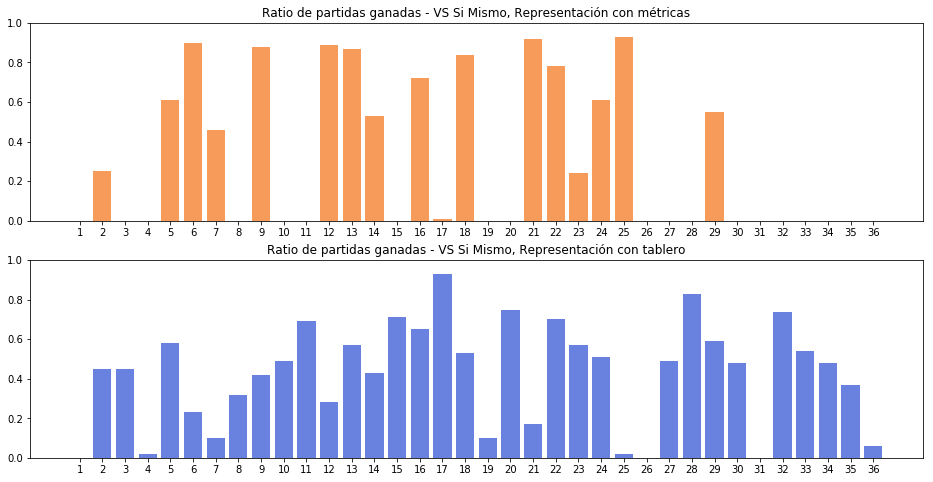

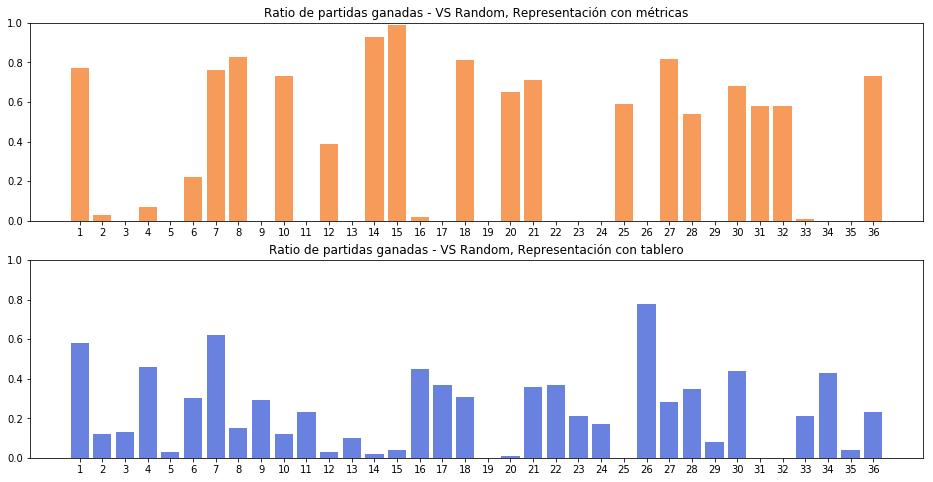

In [2]:
# Graficas de Win Rate para todos los jugadores.
%matplotlib inline
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from utils.const import CompareOps
from ntCompare import plot

plot(CompareOps.WIN_RATE)

A partir de las gráficas se observa que:
- Los modelos que reciben métricas como entradas lograron alcanzar consistentamente un mejor Win Rate en contra de ambos  tipos de oponentes.
- Los modelos que reciben el tablero como entrada tuvieron resultados de muy baja calidad al enfrentarse al *oponente aleatorio*.
- Para ambos modelos el resto de los parámetros impactó fuertemente en sus resultados, sin embargo se observa que los modelos que reciben el tablero como entrada tienen una distribución un tanto más uniforme de sus resultados que los modelos que reciben métricas como entrada.
- Para ambos tipos de modelos se observa que no necesariamente una configuración que tenga buenos resultados contra un tipo de oponente los tendrá con el otro.
    - Se destaca el jugador N° 26 con tablero. Alcanzó el Win Rate más alto vs un oponente aleatorio pero también el más bajo contra si mismo (Empatando todas las partidas).
    - Observaciones análogas pueden realizarse para múltiples jugadores.

##### 3.4.1.2 Análisis del Victory Rate
***

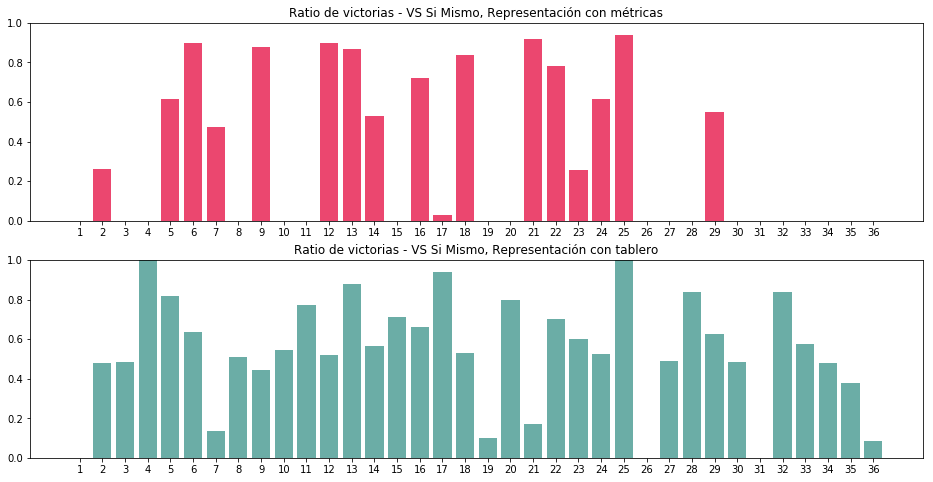

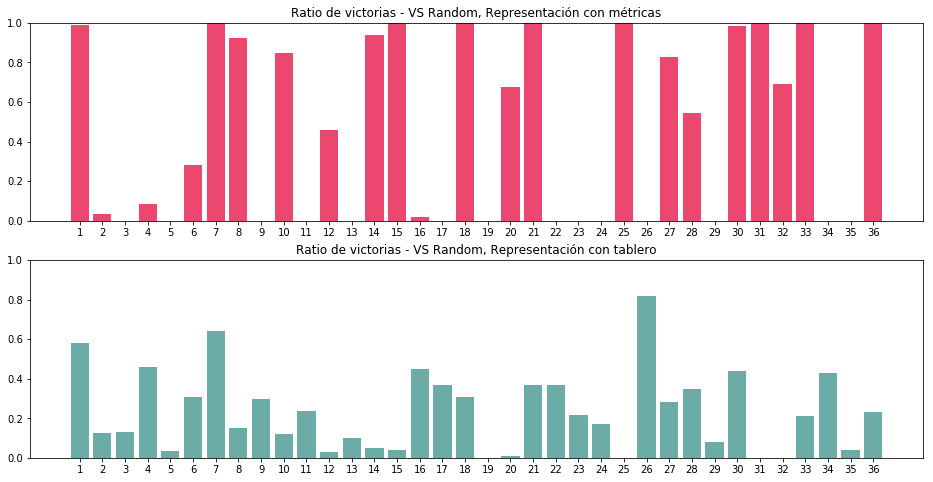

In [1]:
# Graficas de Victory Rate para todos los jugadores.
%matplotlib inline
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from utils.const import CompareOps
from ntCompare import plot

plot(CompareOps.VICTORY_RATE)

A partir de las gráficas y vinculando el Victory Rate al Win Rate de la sección anterior se observa que:
- Tanto los jugadores que fueron entrenados en contra del *oponente previo* y recibian métricas como entrada, así como los jugadores que fueron entrenados en contra del *oponente aleatorio* y recibian el tablero como entrada, tienen una distribución casi idéntica de Win Rate vs Victory Rate entre si, esto es a causa de que la cantidad de empates ocurridos en el entrenamiento de estos jugadores fue casi nula.

#### 3.4.2. Análisis cualitativo
***

A continuación se brindan graficas que muestran el impacto en la curva del Win Rate promedio para subconjuntos determinados por cada uno de los valores de un posible parámetro en la configuración.

A diferencia de la sección anterior, esta sección si se concentra en determinar (para cada uno de los subconjuntos definidos en la sección anterior) cuales configuraciones del modelo *MLPRegressor* dieron en general un mejor resultado para el algoritmo.

##### 3.4.2.1 Análisis del impacto de la arquitectura de capas ocultas en base al Win Rate
***

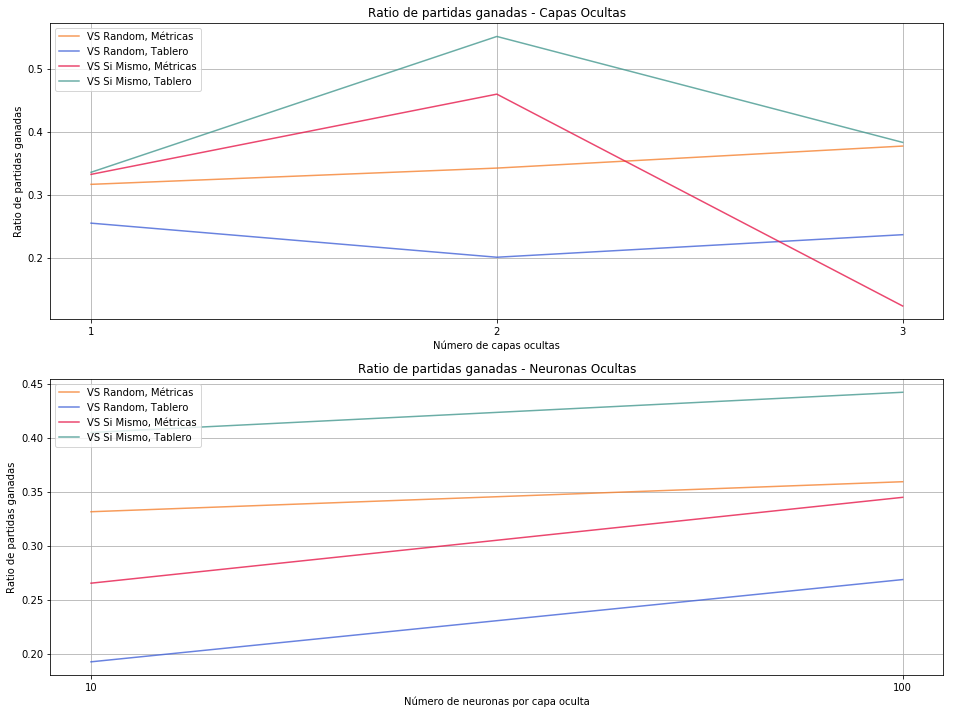

In [3]:
# Curvas de impacto de la arquitectura de capas ocultas para el Win Rate promedio de los jugadores.
%matplotlib inline
from utils.const import CompareOps
from ntCompare import plot

plot(CompareOps.HIDDEN_LAYERS)

A partir de las gráficas se observa que:
- Los jugadores entrenados en contra del *oponente previo* tuvieron una mejor performance para dos capas ocultas.
    - Una observación similar no se puede dar para los jugadores entrenados en contra del *oponente aleatorio*, dado que los que recibian el tablero como entrada tuvieron mejor perfomance para una capa oculta, mientras que los que recibian métricas como entrada tuvieron mejor performance para tres.
- Contar con 100 neuronas en cada capa oculta siempre dio mejores resultados que contar con 10 neuronas en cada capa oculta.

##### 3.4.2.2 Análisis del impacto de la función de activación en base al Win Rate
***

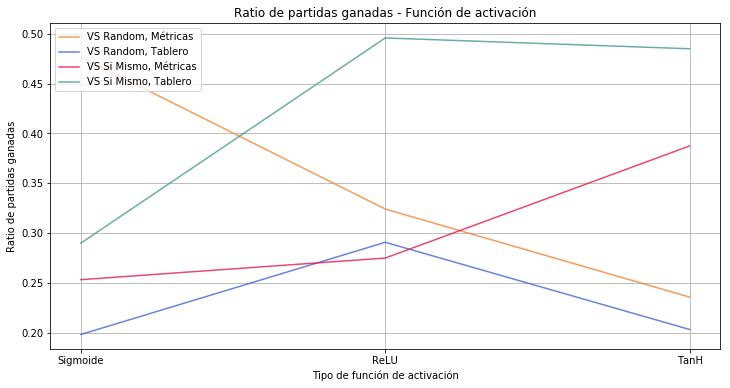

In [4]:
# Curvas de impacto de la función de activación para el Win Rate promedio de los jugadores.
%matplotlib inline
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from utils.const import CompareOps
from ntCompare import plot

plot(CompareOps.ACTIVATION)

A partir de la gráfica se observa que:
- La función Sigmoide dio un muy mal resultado para todos los conjuntos de jugadores salvo los que reciben métricas de entrada y fueron entrenados contra el *oponente previo*, en donde la función Sigmoide tuvo drásticamente la mejor performance.
- La función ReLU tuvo la mejor performance para los jugadores que reciben el tablero como entrada.
- La función TanH tuvo muy buena performance para los jugadores que se enfrentaron al *oponente previo*, sin embargo dio resultados de muy mala calidad para los jugadores que fueron enfrentados al *oponente aleatorio*.

##### 3.4.2.3 Análisis del impacto del ratio de aprendizaje en base al Win Rate
***

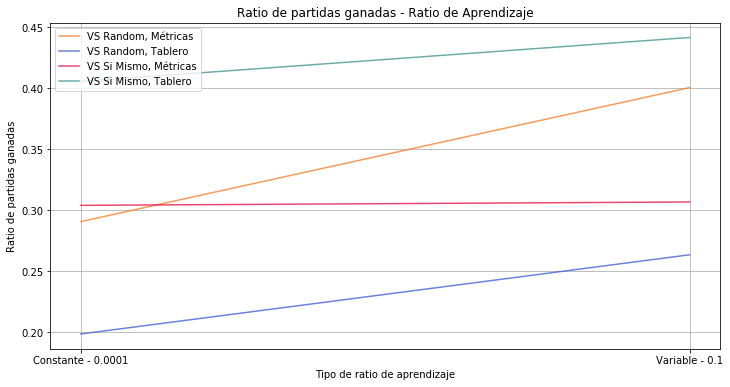

In [5]:
# Curvas de impacto del ratio de aprendizaje para el Win Rate promedio de los jugadores.
%matplotlib inline
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from utils.const import CompareOps
from ntCompare import plot

plot(CompareOps.LEARNING_RATE)

A partir de la gráfica se observa que:
- El ratio de aprendizaje variable con valor inicial en 0.1 tuvo mejor performance que constante para todos los jugadores salvo los que recibian métricas como entrada y fueron enfrentados al *oponente previo* (en este caso no pareció haber afectado la calidad de los resultados).

#### 3.4.3. Representantes
***

Se dividieron los jugadores a evaluar según si habian sido entrenados contra el *oponente aleatorio* o contra el *oponente previo*, para ambos conjuntos se seleccionó a los 8 jugadores con mayor **_win rate_**, los cuales pasarán a la siguiente etapa de ponderación de representantes (el torneo).

##### 3.4.3.1 Mejores jugadores entrenados contra el *oponente aleatorio*
**TODO: Sacar titulos de las tablas?)**

<table>
    <tr>
        <th>Modelo</th>
        <th>Función de activación</th>
        <th>Arquitectura de las capas ocultas</th>
        <th>Ratio de aprendizaje</th>
        <th>Partidas ganadas</th>
    </tr>
    <tr>
        <td>Tablero</td>
        <td>ReLU</td>
        <td>(10, 10)</td>
        <td>Constante</td>
        <td>80%</td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <caption>Mejores jugadores entrenados contra el <i>oponente aleatorio</i></caption>
</table>

##### 3.2.2.2 Mejores jugadores entrenados contra el *oponente previo*

<table>
    <tr>
        <th>Modelo</th>
        <th>Función de activación</th>
        <th>Arquitectura de las capas ocultas</th>
        <th>Ratio de aprendizaje</th>
        <th>Partidas ganadas</th>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <caption>Mejores jugadores entrenados contra el <i>oponente previo</i></caption>
</table>


### 3.5. Ponderación de representantes
***
A

In [ ]:
# Script que permite simular torneo

In [ ]:
# Script que grafica y muestra tabla de resultados de torneo

### 3.6. Comparación con jugador lineal
***
A

In [ ]:
# Script que permite simular partido entre la mejor red y el lineal 
# Renzo: Si entiendo bien la letra del práctico 1, hay que hacer 100 partidas entre estos.

In [ ]:
# Script que grafica y muestra tabla de resultados del partido

### 3.7. Script para jugar
***

A continuación se adjunta un script que permite jugar partidas de damas chinas contra los mejores jugadores.

In [ ]:
# Script 2 - Lector vs Jugadores
import ntPlay

## 4. Conclusiones
***

#### 4.1. Respecto al Modelo
***
A

#### 4.2. Respecto a los Parámetros
***
A

#### 4.3. Respecto a los Resultados
***
A

#### 4.4. Respecto a los Oponentes
***
A

#### 4.5. Posibles mejoras
***
A:
- A
- A